# Classification analysis

In [16]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Baseline multinomial logistic regression: elbow on C + MI bars
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_validate



## Data cleaning

In [17]:
# Data is located one folder up, in output/violations. (This is run inside a notebook)

RANDOM_SEED = 42
datapath = os.path.join(os.path.dirname(os.getcwd()), 'output', 'violations', 'violations_used_for_analysis_new.csv')
# datapath = os.path.join(os.path.dirname(os.getcwd()), 'output', 'violations', 'violations_output.csv')

df_uncleaned = pd.read_csv(datapath)

# Select only the columns we succesfully normalized (start with 'scaled_')
scaled_columns = [col for col in df_uncleaned.columns if col.startswith('scaled_')]
df_uncleaned = df_uncleaned[['jrpid', 'composer'] + scaled_columns]

# Remove the 'scaled_' prefix from the column names
df_uncleaned.columns = df_uncleaned.columns.str.replace('scaled_', '', regex=False)



# Merge columns that belong to the same composer
composer_map: dict[str, list[str]] = {
        "Busnoys": ['Busnoys, Antoine', "Busnoys, Antoine (COA)", "Busnoys, Antoine (COA1)"],
        "Compere": ['Compere, Loyset'],
        "Du Fay": ['Du Fay, Guillaume'],
        "Isaac": ['Isaac'],
        "Japart": ['Japart, Jean'],
        "Okeghem": ['Okeghem, Johannes', "Johannes Okeghem", "Okeghem, Johannes (COA)", "Okeghem, Johannes (COA1)"],
        "Josquin": ['Josquin des Prez', "Josquin des Prez (COA)"],
        "la Rue": ['la Rue, Pierre de', "La Rue"],
        "Martini": ['Martini, Johannes', "Martini, Johannes (COA)"],
        "Tinctoris": ['Tinctoris, Johannes'],
        "de Orto": ['de Orto, Marbrianus', "de Orto, Marbrianus (COA)"],
    }


# Drop rows with any nan values in the features
nan_count = df_uncleaned.isna().sum().sum()
print(f"Found {nan_count} NaN values in the dataset.\n")
df_uncleaned = df_uncleaned.dropna()


for canonical, alternatives in composer_map.items():
    # Replace any alternative composer label with the canonical one
    df_uncleaned.loc[df_uncleaned['composer'].isin(alternatives), 'composer'] = canonical

composer_counts = df_uncleaned['composer'].value_counts()
# Print composer counts
print(composer_counts)


Found 0 NaN values in the dataset.

composer
la Rue       129
Josquin      113
Martini      113
Busnoys       61
Okeghem       58
de Orto       32
Compere       27
Japart        21
Du Fay        17
Tinctoris     10
Isaac          1
Name: count, dtype: int64


In [18]:
dropped_composers = ["Tinctoris", "Du Fay", "Isaac", "Japart"]
df_uncleaned = df_uncleaned[~df_uncleaned['composer'].isin(dropped_composers)]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_uncleaned['composer'])
df_uncleaned['composer_encoded'] = y_encoded

# Store the mapping for later recovery
composer_classes = label_encoder.classes_

print(f"Encoded {len(composer_classes)} composers:")
composer_counts = df_uncleaned['composer'].value_counts()
for i, composer in enumerate(composer_classes):
    count = composer_counts[composer]
    print(f"  {i}: {composer} ({count} pieces)")

Encoded 7 composers:
  0: Busnoys (61 pieces)
  1: Compere (27 pieces)
  2: Josquin (113 pieces)
  3: Martini (113 pieces)
  4: Okeghem (58 pieces)
  5: de Orto (32 pieces)
  6: la Rue (129 pieces)


In [19]:
df_cleaned = df_uncleaned

## Exploratory analysis

In [20]:
X = df_cleaned.drop(columns=['composer', 'jrpid', 'composer_encoded'])
y = df_cleaned['composer_encoded']


In [21]:
# compute composer-average feature matrix
avg_by_composer = df_cleaned.groupby('composer')[X.columns].mean()

# prepare feature numbers
feat_nos = [col.split(',')[-1] for col in avg_by_composer.columns]

# formatting widths
name_w = 25
num_w = 8

# header row: feature numbers
header = ' ' * name_w + ''.join(f"{fn:>{num_w}}" for fn in feat_nos)
print(header)

multiplier = 100

# one row per composer
# for composer, row in avg_by_composer.iterrows():
    # vals = ''.join(f"{multiplier*v:>{num_w}.3f}" for v in row.values)
    # print(f"{composer:<{name_w}}{vals}")
    
display(avg_by_composer.mul(1).round(5))

                               15      22      23      25      26      27      28      32      34      35      36      41      42      43      44      48


,"tie_into_weak_beat, 15","leap_too_large, 22","leap_approach_left_opposite, 23","interval_order_motion, 25","successive_leap_opposite_direction, 26","leap_up_accented_long_note, 27","eight_pair_stepwise, 28","leading_tone_approach_step, 32","ascending_leap_strong_quarter, 34","ascending_leap_to_from_quarter, 35","leap_in_quarters_balanced, 36","contrary_motion, 41","oblique_motion, 42","parallel_motion, 43","similar_motion, 44","parallel_fifth_octave, 48"
composer,,,,,,,,,,,,,,,,
Busnoys,0.00003,0.00119,0.00563,0.00636,0.04096,0.06247,0.00030,0.00144,0.00028,0.00026,0.00143,0.08843,0.13227,0.01777,0.04964,0.00413
Compere,0.00000,0.00004,0.00285,0.00117,0.02959,0.04768,0.00049,0.00092,0.00101,0.00048,0.00033,0.07911,0.12986,0.02574,0.04515,0.00637
Josquin,0.00000,0.00058,0.00235,0.00362,0.04631,0.06418,0.00005,0.00170,0.00051,0.00022,0.00305,0.05013,0.09009,0.01308,0.02783,0.00317
Martini,0.00000,0.00027,0.00296,0.00275,0.03057,0.04464,0.00034,0.00178,0.00040,0.00036,0.00096,0.06512,0.10758,0.09265,0.06053,0.00343
Okeghem,0.00000,0.00025,0.00455,0.00411,0.04180,0.06724,0.00152,0.00258,0.00120,0.00083,0.00553,0.07271,0.10336,0.01642,0.04397,0.00379
de Orto,0.00000,0.00068,0.00476,0.00462,0.05279,0.06629,0.00005,0.00204,0.00051,0.00027,0.00085,0.06181,0.09315,0.01206,0.03509,0.00364
la Rue,0.00025,0.00048,0.00282,0.00228,0.03888,0.04901,0.00021,0.00221,0.00034,0.00017,0.00132,0.04498,0.08523,0.01474,0.02774,0.00316


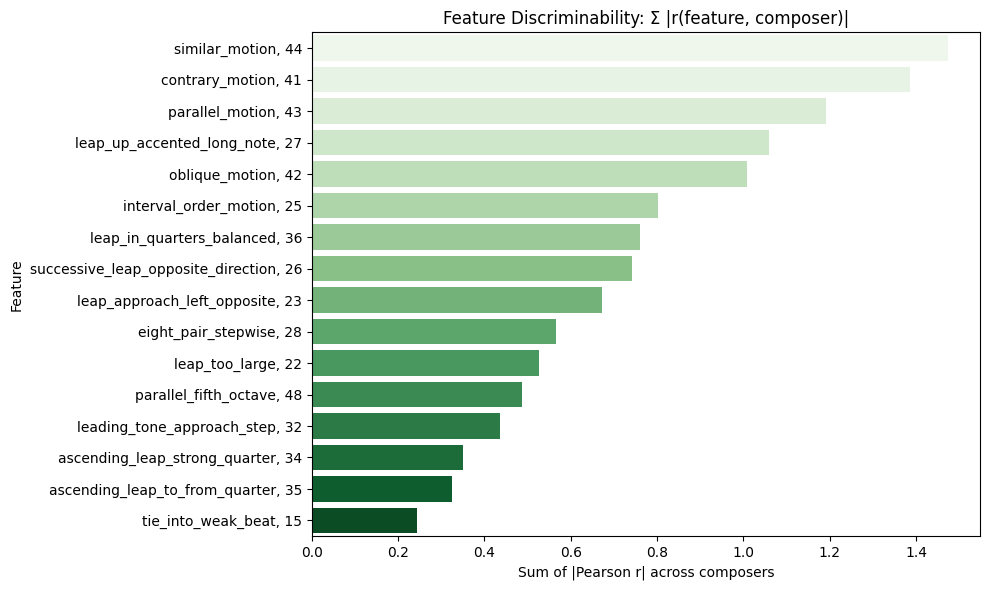

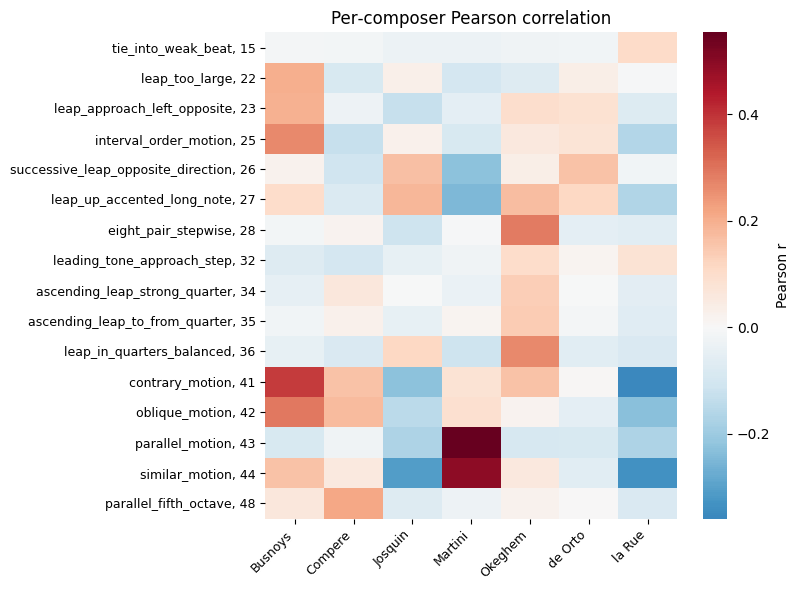

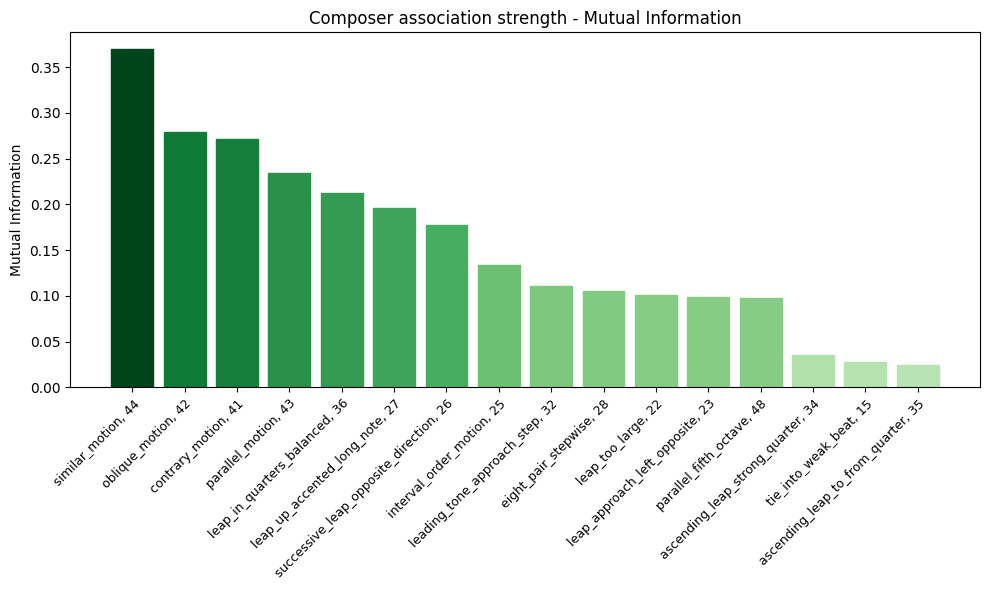

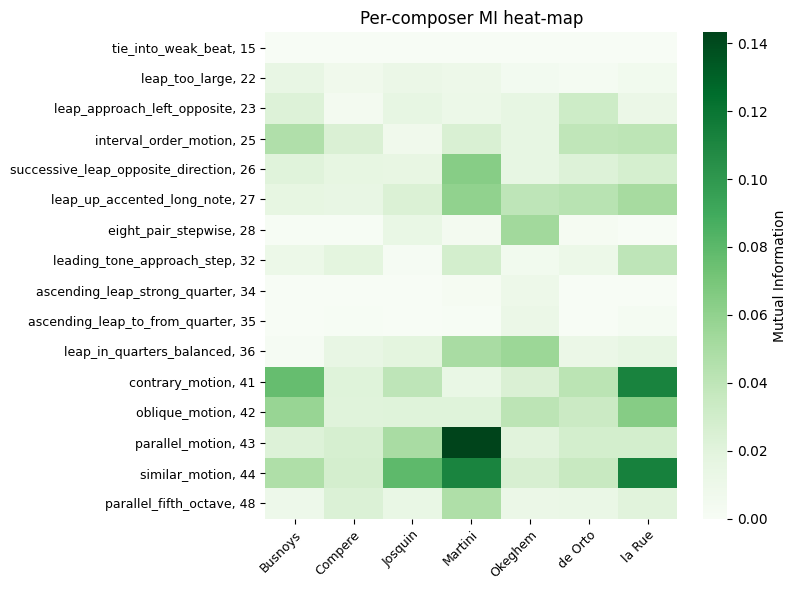

In [22]:
# --- Feature–label association strength  (Mutual Information) ---
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics         import mutual_info_score
from scipy.stats import pearsonr


# --------- Pearson ----------
# --- Summed absolute per‐composer Pearson correlations per feature ---
def plot_summed_abs_pearson(X: pd.DataFrame,
                            composers: list[str]) -> None:
    """
    Compute Pearson r(feature, each composer binary label),
    sum absolute values across composers, and bar‐plot the results.
    """
    # build matrix [n_features × n_composers]
    pearson_mat = np.zeros((X.shape[1], len(composers)))
    for j, comp in enumerate(composers):
        y_bin = (df_cleaned["composer"] == comp).astype(int)
        for i, feat in enumerate(X.columns):
            pearson_mat[i, j] = pearsonr(X[feat], y_bin)[0]

    # sum absolute correlations per feature
    abs_sum = np.sum(np.abs(pearson_mat), axis=1)
    df_sum = pd.DataFrame({
        "feature": X.columns,
        "sum_abs_r": abs_sum
    }).sort_values("sum_abs_r", ascending=False)

    # plot
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=df_sum,
        x="sum_abs_r", y="feature",
        palette="Greens"
    )
    plt.xlabel("Sum of |Pearson r| across composers")
    plt.ylabel("Feature")
    plt.title("Feature Discriminability: Σ |r(feature, composer)|")
    plt.tight_layout()
    plt.show()

# call the function
plot_summed_abs_pearson(X, composer_classes)


# Heatmap

pearson_matrix = np.zeros((len(X.columns), len(composer_classes)))

for j, comp_label in enumerate(composer_classes):
    y_bin = (df_cleaned['composer'] == comp_label).astype(int)
    for i, col in enumerate(X.columns):
        pearson_matrix[i,j] = pearsonr(X[col], y_bin)[0]

plt.figure(figsize=(8,6))
sns.heatmap(
    pearson_matrix,
    cmap='RdBu_r',
    center=0,
    cbar_kws={'label':'Pearson r'},
    xticklabels=composer_classes,
    yticklabels=X.columns
)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.title("Per‐composer Pearson correlation")
plt.tight_layout()
plt.show()


# --------- Mutual information ----------

mi = mutual_info_classif(X, y, random_state=RANDOM_SEED)
assoc_df = (
    pd.DataFrame({"feature": X.columns, "MI": mi})
      .sort_values("MI", ascending=False)
)

# Bar chart with Greens colormap
plt.figure(figsize=(10, 6))
bars = plt.bar(assoc_df["feature"], assoc_df["MI"])

# Apply Greens colormap to bars based on MI values, not position
# Normalize MI values to 0-1 range for colormap
mi_normalized = (assoc_df["MI"] - assoc_df["MI"].min()) / (assoc_df["MI"].max() - assoc_df["MI"].min())
colors = plt.cm.Greens(mi_normalized * 0.7 + 0.3)  # Scale to 0.3-1.0 range to avoid too light colors

for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.xticks(
    rotation=45,
    ha='right',
    rotation_mode='anchor',
    fontsize=9,
)
plt.ylabel("Mutual Information")
plt.title("Composer association strength - Mutual Information")
plt.tight_layout()
plt.show()


# --- Per‐composer MI heat-map using actual composer names ---
mi_matrix = np.zeros((len(X.columns), len(composer_classes)))
for j, comp_label in enumerate(composer_classes):
    # binarize y for this composer
    y_bin = (df_cleaned["composer"] == comp_label).astype(int)
    for i, col in enumerate(X.columns):
        mi_matrix[i, j] = mutual_info_score(
            pd.qcut(X[col],
                    q=min(10, len(X)//3),
                    duplicates="drop"),
            y_bin
        )

# Heatmap with Greens colormap
plt.figure(figsize=(8, 6))
sns.heatmap(
    mi_matrix,
    cmap='Greens',  # Changed to Greens colormap
    cbar_kws={"label": "Mutual Information"},
    xticklabels=composer_classes,
    yticklabels=X.columns
)
plt.xticks(
    rotation=45,
    ha='right',
    rotation_mode='anchor',
    fontsize=9,
)
plt.yticks(rotation=0, fontsize=9)
plt.title("Per-composer MI heat-map")
plt.tight_layout()
plt.show()

c:\Python\Lib\site-packages\seaborn\matrix.py:262: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


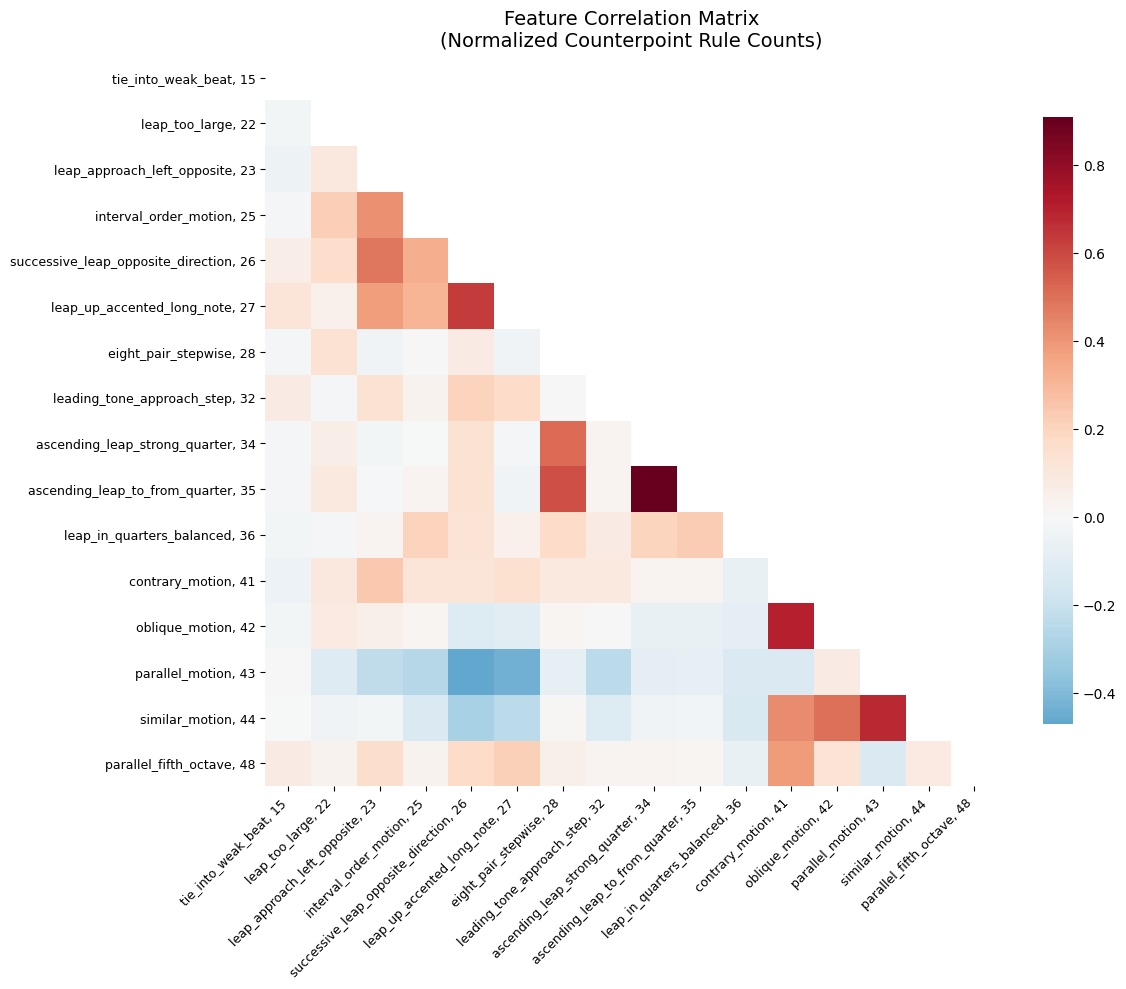


Correlation Summary:
  Mean absolute correlation: 0.143
  Max correlation: 0.909
  Min correlation: -0.469
  # correlations > 0.7: 2
  # correlations > 0.5: 6

Highly correlated pairs (|r| > 0.0):
  ascending_leap_strong_quarter, 34 ↔ ascending_leap_to_from_quarter, 35: r = 0.909
  contrary_motion, 41 ↔ oblique_motion, 42: r = 0.709
  parallel_motion, 43 ↔ similar_motion, 44: r = 0.682
  successive_leap_opposite_direction, 26 ↔ leap_up_accented_long_note, 27: r = 0.636
  eight_pair_stepwise, 28 ↔ ascending_leap_to_from_quarter, 35: r = 0.580
  eight_pair_stepwise, 28 ↔ ascending_leap_strong_quarter, 34: r = 0.512
  oblique_motion, 42 ↔ similar_motion, 44: r = 0.497
  leap_approach_left_opposite, 23 ↔ successive_leap_opposite_direction, 26: r = 0.485
  successive_leap_opposite_direction, 26 ↔ parallel_motion, 43: r = -0.469
  leap_up_accented_long_note, 27 ↔ parallel_motion, 43: r = -0.434
  contrary_motion, 41 ↔ similar_motion, 44: r = 0.427
  leap_approach_left_opposite, 23 ↔ interva

In [23]:
# Add this cell to your classification.ipynb notebook

import seaborn as sns
from scipy.stats import pearsonr, spearmanr

# --- Correlation Analysis ---
# Calculate correlation matrix
corr_matrix = X.corr()

# Create the heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle

sns.heatmap(
    corr_matrix, 
    mask=mask,
    annot=True, 
    cmap='RdBu_r', 
    center=0,
    square=True,
    fmt='.2f',
    cbar_kws={"shrink": .8},
    annot_kws={'size': 8}
)

plt.title('Feature Correlation Matrix\n(Normalized Counterpoint Rule Counts)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

# --- Summary statistics ---
# Get upper triangle of correlation matrix (excluding diagonal)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
correlations = upper_tri.stack().values

print(f"\nCorrelation Summary:")
print(f"  Mean absolute correlation: {np.mean(np.abs(correlations)):.3f}")
print(f"  Max correlation: {np.max(correlations):.3f}")
print(f"  Min correlation: {np.min(correlations):.3f}")
print(f"  # correlations > 0.7: {np.sum(np.abs(correlations) > 0.7)}")
print(f"  # correlations > 0.5: {np.sum(np.abs(correlations) > 0.5)}")

# --- Identify highly correlated pairs ---
high_corr_threshold = 0.
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > high_corr_threshold:
            high_corr_pairs.append((
                corr_matrix.columns[i], 
                corr_matrix.columns[j], 
                corr_val
            ))

if high_corr_pairs:
    print(f"\nHighly correlated pairs (|r| > {high_corr_threshold}):")
    for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"  {feat1} ↔ {feat2}: r = {corr:.3f}")
else:
    print(f"\nNo highly correlated pairs found (|r| > {high_corr_threshold})")

In [24]:
# For all the highly correlated (>0.8) feature pairs, remove one of them, based on lowest MI
X = X.drop(columns=['ascending_leap_to_from_quarter, 35'])
y = y

c:\Python\Lib\site-packages\seaborn\matrix.py:262: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


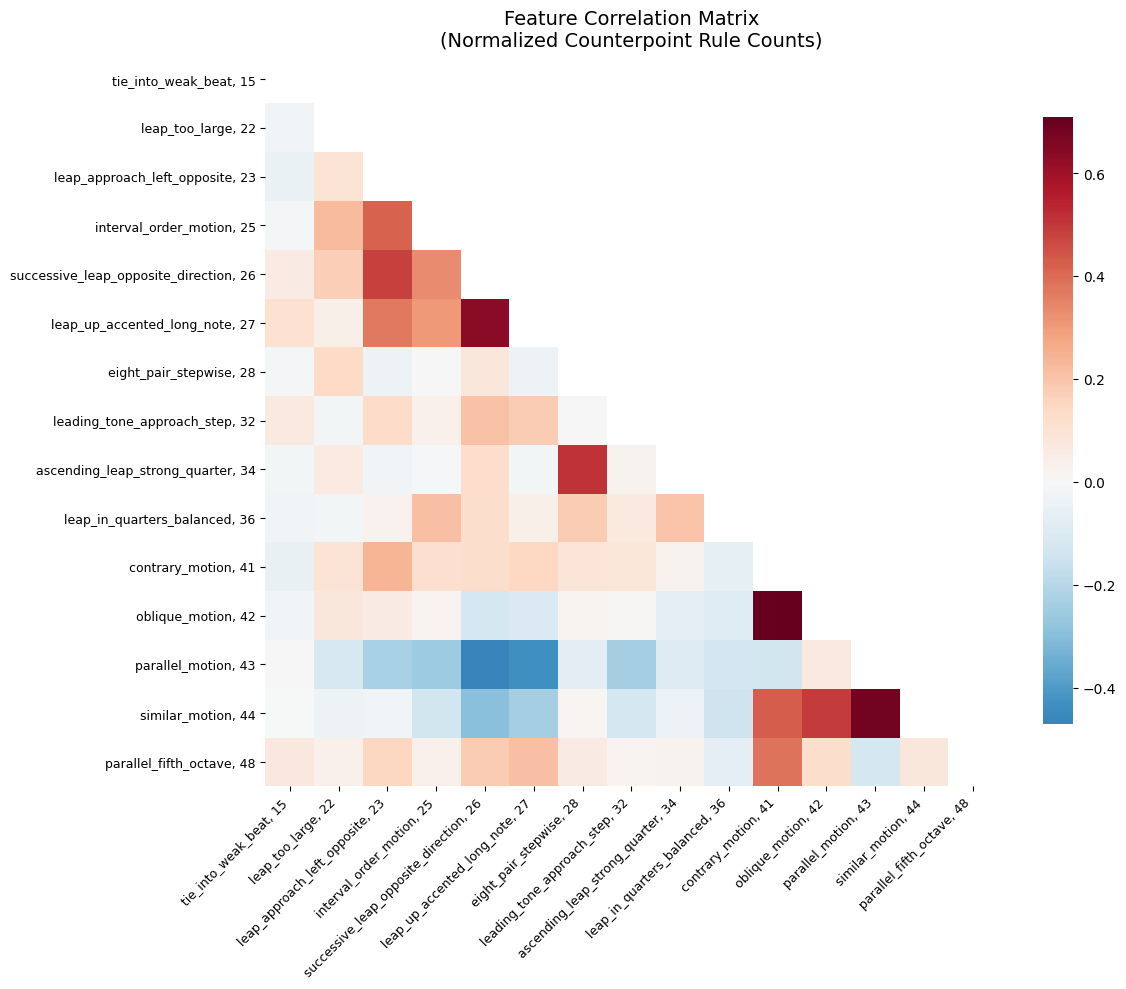


Correlation Summary:
  Mean absolute correlation: 0.142
  Max correlation: 0.709
  Min correlation: -0.469
  # correlations > 0.7: 1
  # correlations > 0.5: 4

Highly correlated pairs (|r| > 0.7):
  contrary_motion, 41 ↔ oblique_motion, 42: r = 0.709


In [25]:



corr_matrix = X.corr()

# Create the heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle

sns.heatmap(
    corr_matrix, 
    mask=mask,
    annot=True, 
    cmap='RdBu_r', 
    center=0,
    square=True,
    fmt='.2f',
    cbar_kws={"shrink": .8},
    annot_kws={'size': 8}
)

plt.title('Feature Correlation Matrix\n(Normalized Counterpoint Rule Counts)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

# --- Summary statistics ---
# Get upper triangle of correlation matrix (excluding diagonal)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
correlations = upper_tri.stack().values

print(f"\nCorrelation Summary:")
print(f"  Mean absolute correlation: {np.mean(np.abs(correlations)):.3f}")
print(f"  Max correlation: {np.max(correlations):.3f}")
print(f"  Min correlation: {np.min(correlations):.3f}")
print(f"  # correlations > 0.7: {np.sum(np.abs(correlations) > 0.7)}")
print(f"  # correlations > 0.5: {np.sum(np.abs(correlations) > 0.5)}")

# --- Identify highly correlated pairs ---
high_corr_threshold = 0.7
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > high_corr_threshold:
            high_corr_pairs.append((
                corr_matrix.columns[i], 
                corr_matrix.columns[j], 
                corr_val
            ))

if high_corr_pairs:
    print(f"\nHighly correlated pairs (|r| > {high_corr_threshold}):")
    for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"  {feat1} ↔ {feat2}: r = {corr:.3f}")
else:
    print(f"\nNo highly correlated pairs found (|r| > {high_corr_threshold})")


## Create train/val datasets

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# --- Train-validation split (stratified by composer) ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_SEED, 
    stratify=y
)

## Classification baseline - logistic regression

### Parameter tuning

In [27]:
# --- Build pipeline ---

# 1. Settings
class_weight = 'balanced'
n_splits = 5
parameter_value_tolerance = 0.01
cv = StratifiedKFold(
    n_splits=n_splits, 
    shuffle=True,
    random_state=RANDOM_SEED
)

# 2. Define pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        #penalty="l1",
        penalty='elasticnet', l1_ratio=0.5,
        solver="saga",
        multi_class="ovr",
        max_iter=5000,
        class_weight=class_weight,
        random_state=RANDOM_SEED,
        tol=parameter_value_tolerance,               
        warm_start=True,
        n_jobs=-1
    ))
])

# Prepare storage
C_values = np.logspace(-3, 0, 12)
f1_macro = []
balanced_acc = []
f1_train = []  # NEW: training scores
balanced_acc_train = []  # NEW: training scores
features_mean = []
features_std = []

for C in tqdm(C_values, desc="Hyperparameter search"):
    pipe.set_params(clf__C=C, clf__warm_start=True)

    # Get both train and validation scores
    scores = cross_validate(
        pipe, X_train, y_train,
        cv=cv,
        scoring={"f1": "f1_macro", "bal": "balanced_accuracy"},
        return_estimator=True,
        return_train_score=True,  # NEW: get training scores
        n_jobs=-1
    )

    # Validation scores (what we had before)
    f1_macro.append(scores["test_f1"].mean())
    balanced_acc.append(scores["test_bal"].mean())
    
    # NEW: Training scores
    f1_train.append(scores["train_f1"].mean())
    balanced_acc_train.append(scores["train_bal"].mean())

    # Count non-zero features in each fold’s model
    nonzero_counts = []
    for est in scores["estimator"]:
        coef = est.named_steps["clf"].coef_
        # count features with any class coefficient ≠ 0
        nonzero_counts.append(np.sum(np.any(coef != 0, axis=0)))

    # store mean and std
    features_mean.append(np.mean(nonzero_counts))
    features_std.append(np.std(nonzero_counts))

    



Hyperparameter search: 100%|██████████| 12/12 [00:15<00:00,  1.28s/it]


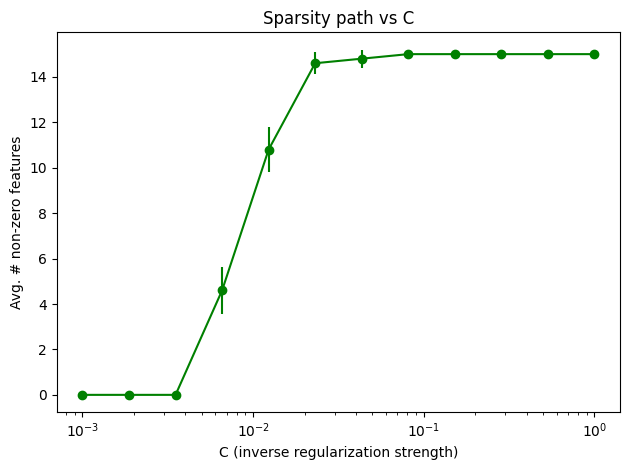

In [28]:
plt.errorbar(
    C_values, features_mean, yerr=features_std, 
    color='green', marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel('C (inverse regularization strength)')
plt.ylabel('Avg. # non-zero features')
plt.title('Sparsity path vs C')
plt.tight_layout()
plt.show()

Elbow analysis results:
  Features elbow:     C=0.0123, #feat≈10.8±1.0
  F1-macro elbow:     C=0.0123, score=0.409
  Balanced-acc elbow: C=0.0123, score=0.441


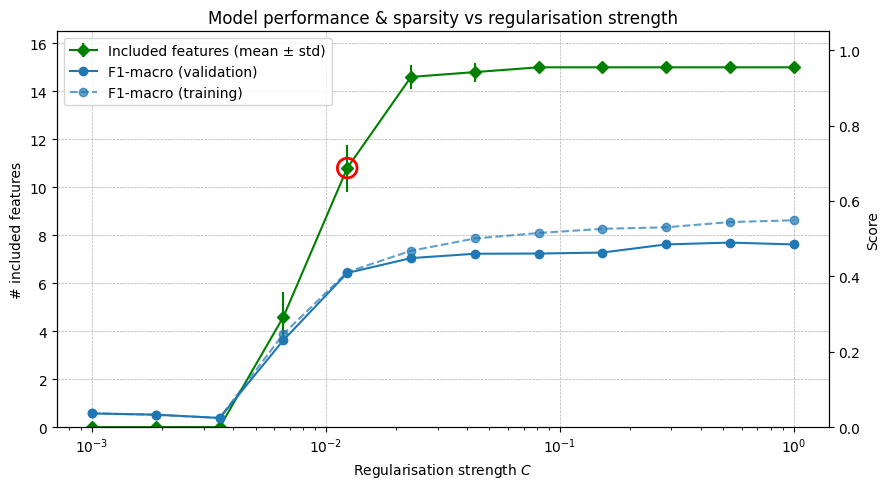

In [29]:
# --- determine elbow points to plot ---
f1_elbow_idx      = 4
bal_acc_elbow_idx = 4
feature_elbow_idx = 4

# get the C and y-values at each elbow
C_feat, y_feat = C_values[feature_elbow_idx], features_mean[feature_elbow_idx]
C_f1,   y_f1   = C_values[f1_elbow_idx],     f1_macro[f1_elbow_idx]
C_bal,  y_bal  = C_values[bal_acc_elbow_idx], balanced_acc[bal_acc_elbow_idx]

# --- create figure ---
fig, ax1 = plt.subplots(figsize=(9, 5))
ax1.set_xscale('log')
ax1.set_xlabel('Regularisation strength $C$')
ax1.set_ylabel('# included features', color='black')

# --- plot sparsity with error bars ---
ax1.errorbar(
    C_values, features_mean,
    yerr=features_std,
    marker='D', linestyle='-',
    label='Included features (mean ± std)',
    color='green'
)
ax1.set_ylim(0, max(features_mean) * 1.1)
ax1.grid(True, which='major', linestyle='--', linewidth=0.5)

ax1.set_ylim(0, max(features_mean) * 1.1)
ax1.grid(True, which='major', linestyle='--', linewidth=0.5)

# Secondary axis
ax2 = ax1.twinx()

# Plot f1 train and test (blue)
ax2.plot(C_values, f1_macro, 'o-', label='F1-macro (validation)', color='tab:blue')
ax2.plot(C_values, f1_train, 'o--', label='F1-macro (training)', color='tab:blue', alpha=0.7)

# Balanced Accuracy = (Sensitivity + Specificity) / 2.
# Plot balanced accuracy train and test (orange)
# ax2.plot(C_values, balanced_acc, 's-', label='Balanced accuracy (validation)', color='tab:orange')
# ax2.plot(C_values, balanced_acc_train, 's--', label='Balanced accuracy (training)', color='tab:orange', alpha=0.7)

ax2.set_ylabel('Score')
ax2.set_ylim(0, 1.05)

# Highlight elbow points
ax1.scatter([C_feat], [y_feat], s=200, facecolors='none', edgecolors='red', linewidths=2, zorder=5)

# Print and legend (unchanged)
print("Elbow analysis results:")
print(f"  Features elbow:     C={C_feat:.3g}, #feat≈{y_feat:.1f}±{features_std[feature_elbow_idx]:.1f}")
print(f"  F1-macro elbow:     C={C_f1:.3g}, score={y_f1:.3f}")
print(f"  Balanced-acc elbow: C={C_bal:.3g}, score={y_bal:.3f}")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Model performance & sparsity vs regularisation strength')
plt.tight_layout()
plt.show()

### Train full model, run on test set

In [30]:
optimal_C = C_values[feature_elbow_idx]  # or choose based on your elbow analysis
pipe.set_params(clf__C=optimal_C)
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_val)
val_f1 = f1_score(y_val, y_pred, average='macro')
val_bal_acc = balanced_accuracy_score(y_val, y_pred)

# --- Detailed classification report ---
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=composer_classes))


Classification Report:
              precision    recall  f1-score   support

     Busnoys       0.36      0.67      0.47        12
     Compere       0.17      0.20      0.18         5
     Josquin       0.38      0.22      0.28        23
     Martini       1.00      0.48      0.65        23
     Okeghem       0.67      0.33      0.44        12
     de Orto       0.27      0.67      0.38         6
      la Rue       0.53      0.69      0.60        26

    accuracy                           0.48       107
   macro avg       0.48      0.46      0.43       107
weighted avg       0.56      0.48      0.48       107



None Summary:
  Overall Accuracy: 0.477
  Per-class accuracy (diagonal %):
    Busnoys   :  66.7%  (12 samples)
    Compere   :  20.0%  (5 samples)
    Josquin   :  21.7%  (23 samples)
    Martini   :  47.8%  (23 samples)
    Okeghem   :  33.3%  (12 samples)
    de Orto   :  66.7%  (6 samples)
    la Rue    :  69.2%  (26 samples)


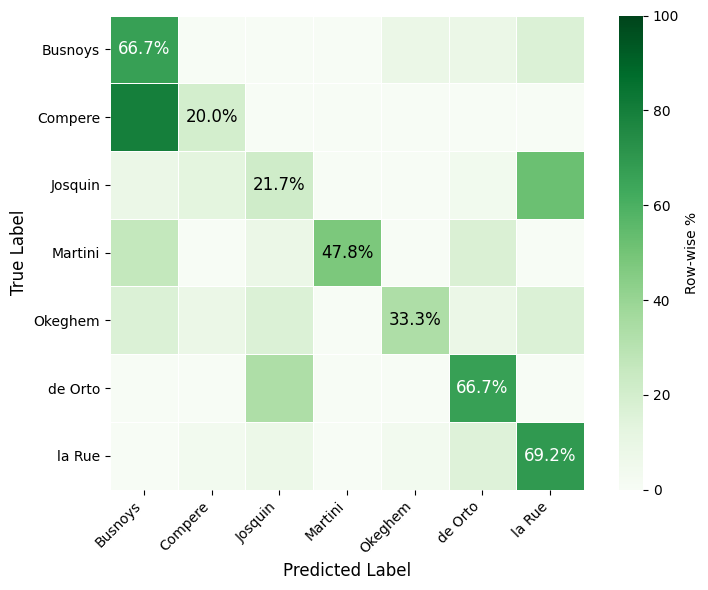


Most frequent misclassifications:
  Busnoys → la Rue: 2 pieces (16.7%)
  Compere → Busnoys: 4 pieces (80.0%)
  Josquin → Compere: 3 pieces (13.0%)
  Josquin → la Rue: 12 pieces (52.2%)
  Martini → Busnoys: 6 pieces (26.1%)
  Martini → de Orto: 4 pieces (17.4%)
  Okeghem → Busnoys: 2 pieces (16.7%)
  Okeghem → Josquin: 2 pieces (16.7%)
  Okeghem → la Rue: 2 pieces (16.7%)
  de Orto → Josquin: 2 pieces (33.3%)
  la Rue → de Orto: 4 pieces (15.4%)


In [31]:
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix_with_percentages(
        y_true, y_pred, class_names, title="Confusion Matrix",
        print_stats=True
        ):
    """
    Plot a confusion matrix heatmap with only diagonal percentage annotations,
    and a color scale fixed from 0% to 100%.
    """
    # Compute confusion matrix and row-wise percentages
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype(float) / cm.sum(axis=1)[:, None] * 100

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot heatmap with fixed color range
    sns.heatmap(
        cm_percent,
        annot=False,
        fmt='',
        cmap='Greens',
        vmin=0,            # minimum of colorbar
        vmax=100,          # maximum of colorbar
        square=True,
        linewidths=0.5,
        cbar_kws={"label": "Row-wise %"},
        xticklabels=class_names,
        yticklabels=class_names,
        ax=ax
    )
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    # Overlay diagonal percentage annotations
    for i in range(cm.shape[0]):
        pct = cm_percent[i, i]
        ax.text(
            i + 0.5, i + 0.5,
            f"{pct:.1f}%",
            ha='center', va='center',
            color='white' if pct > 50 else 'black',
            fontsize=12
        )

    plt.tight_layout()

    # Print summary statistics
    if print_stats:
        total = cm.sum()
        acc = np.trace(cm) / total
        print(f"{title} Summary:")
        print(f"  Overall Accuracy: {acc:.3f}")
        print("  Per-class accuracy (diagonal %):")
        for i, name in enumerate(class_names):
            support = cm[i].sum()
            print(f"    {name:<10}: {cm_percent[i, i]:5.1f}%  ({support} samples)")

    return cm, cm_percent



# Create the confusion matrix
cm, cm_percent = plot_confusion_matrix_with_percentages(
    y_val, y_pred, composer_classes, 
    title=None
)

plt.show()

# cm_percent_df = pd.DataFrame(cm_percent,index=composer_classes,columns=composer_classes).round(1)
# display(cm_percent_df)



# --- Additional Analysis ---

# Most confused pairs
print(f"\nMost frequent misclassifications:")
for i in range(len(composer_classes)):
    for j in range(len(composer_classes)):
        if i != j and cm[i, j] > 0:
            misclass_rate = cm[i, j] / cm[i, :].sum() * 100
            if misclass_rate > 10:  # Show misclassifications > 10%
                print(f"  {composer_classes[i]} → {composer_classes[j]}: {cm[i, j]} pieces ({misclass_rate:.1f}%)")


In [32]:
coef = pipe.named_steps["clf"].coef_
active_mask = np.any(np.abs(coef) > parameter_value_tolerance, axis=0)

# pick an aggregation rule once and reuse it
agg = np.mean(np.abs(coef), axis=0)      # or np.max / np.sum

importance_df = (
    pd.DataFrame({'feature': X_train.columns,
                  'importance': agg,
                  'active': active_mask})
      .sort_values('importance', ascending=False)
      .reset_index(drop=True)
)
#importance_df 

print(f"Active features at C={optimal_C:.3g}: {active_mask.sum()}/{X_train.shape[1]}")

print("\nTop features by |coef|:")
print(importance_df.head(20).to_string(index=False))

Active features at C=0.0123: 11/15

Top features by |coef|:
                               feature  importance  active
                   contrary_motion, 41    0.126345    True
                    similar_motion, 44    0.122242    True
successive_leap_opposite_direction, 26    0.051342    True
             parallel_fifth_octave, 48    0.046791    True
             interval_order_motion, 25    0.042952    True
                   parallel_motion, 43    0.041597    True
               eight_pair_stepwise, 28    0.031006    True
         leap_in_quarters_balanced, 36    0.023928    True
        leap_up_accented_long_note, 27    0.021083    True
                    oblique_motion, 42    0.015448    True
       leap_approach_left_opposite, 23    0.002225    True
                tie_into_weak_beat, 15    0.000000   False
                    leap_too_large, 22    0.000000   False
        leading_tone_approach_step, 32    0.000000   False
     ascending_leap_strong_quarter, 34    0.000000   Fa

In [33]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    pipe, X_val, y_val, n_repeats=30, random_state=0, n_jobs=-1
)
perm_df = pd.DataFrame({
    'feature': X_val.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values('importance_mean', ascending=False)
print(perm_df.head(10))


                                   feature  importance_mean  importance_std
13                      similar_motion, 44         0.083801        0.033129
10                     contrary_motion, 41         0.081931        0.034523
12                     parallel_motion, 43         0.050156        0.025706
6                  eight_pair_stepwise, 28         0.032710        0.011254
3                interval_order_motion, 25         0.022430        0.011472
11                      oblique_motion, 42         0.020249        0.008728
4   successive_leap_opposite_direction, 26         0.016511        0.018007
5           leap_up_accented_long_note, 27         0.014019        0.020008
14               parallel_fifth_octave, 48         0.013396        0.015949
9            leap_in_quarters_balanced, 36         0.011838        0.005360


# Decision tree

In [ ]:
import math

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV

'''
Dont use the trained model above for feature selection bceause:
1. Data-leakage in evaluation
When you compute coefficients on the full training set and then decide which features to keep, you have already “peeked” at every sample.
2. Model-specific importance ≠ universal importance
Logistic coefficients describe linear marginal effects conditioned on all other variables. Decision-trees exploit non-linear, interaction terms
3. Shrunken values are shrunk by design 
Your elastic-net intentionally drives many β → 0 to combat multicollinearity. The ranking therefore reflects regularisation artefacts as much as true relevance. Heavy-correlated blocks often keep one survivor with an inflated |β| and suppress its twins – a tree would happily keep either twin if it helps a split. 
'''

# parse logistic model (same hyper-params as earlier elbow)
lasso = LogisticRegression(
    penalty="l1", solver="saga", multi_class="ovr",
    C=optimal_C, max_iter=5000, class_weight="balanced",
    random_state=RANDOM_SEED, n_jobs=-1
)

# 2 meta-selector drops weak-importance features                       ⬇️
selector = SelectFromModel(lasso, threshold="median")  # keep top-50 %

# 3regularised decision tree (early-stopping + cost-complexity)
tree = DecisionTreeClassifier(
    class_weight="balanced",
    random_state=RANDOM_SEED
)

pipe_dt = Pipeline([
    ("selector", selector),
    ("tree",     tree)
])



# --- dynamically compute max_depth as 10%–100% of feature count, rounded up
n_feat = X_train.shape[1]
depths = sorted({ math.ceil(n_feat * frac)
                  for frac in np.linspace(0.1, 1.0, 10) })
print(f"Grid-search will try tree__max_depth = {depths}")

param_grid = {
    "tree__max_depth":       depths,
    "tree__min_samples_leaf":[1, 2, 5, 10],
    "tree__ccp_alpha":       [0.0, 1e-3, 1e-2]      # post-pruning
}

gs_dt = GridSearchCV(
    pipe_dt, param_grid, cv=cv,
    scoring="f1_macro", n_jobs=-1, refit=True
)
gs_dt.fit(X_train, y_train)

print("Best tree params:", gs_dt.best_params_)
print(f"Val-F1: {gs_dt.best_score_:.3f}")

# 4. evaluate on hold-out validation set
y_pred_dt = gs_dt.predict(X_val)
print("\nDecision-tree report:")
print(classification_report(y_val, y_pred_dt, target_names=composer_classes))

Grid-search will try tree__max_depth = [2, 3, 5, 6, 8, 9, 11, 12, 14, 15]
Best tree params: {'tree__ccp_alpha': 0.0, 'tree__max_depth': 9, 'tree__min_samples_leaf': 2}
Val-F1: 0.410

Decision-tree report:
              precision    recall  f1-score   support

     Busnoys       0.30      0.50      0.37        12
     Compere       0.10      0.20      0.13         5
     Josquin       0.46      0.48      0.47        23
     Martini       0.71      0.52      0.60        23
     Okeghem       0.42      0.42      0.42        12
     de Orto       0.33      0.50      0.40         6
      la Rue       0.53      0.31      0.39        26

    accuracy                           0.43       107
   macro avg       0.41      0.42      0.40       107
weighted avg       0.48      0.43      0.44       107



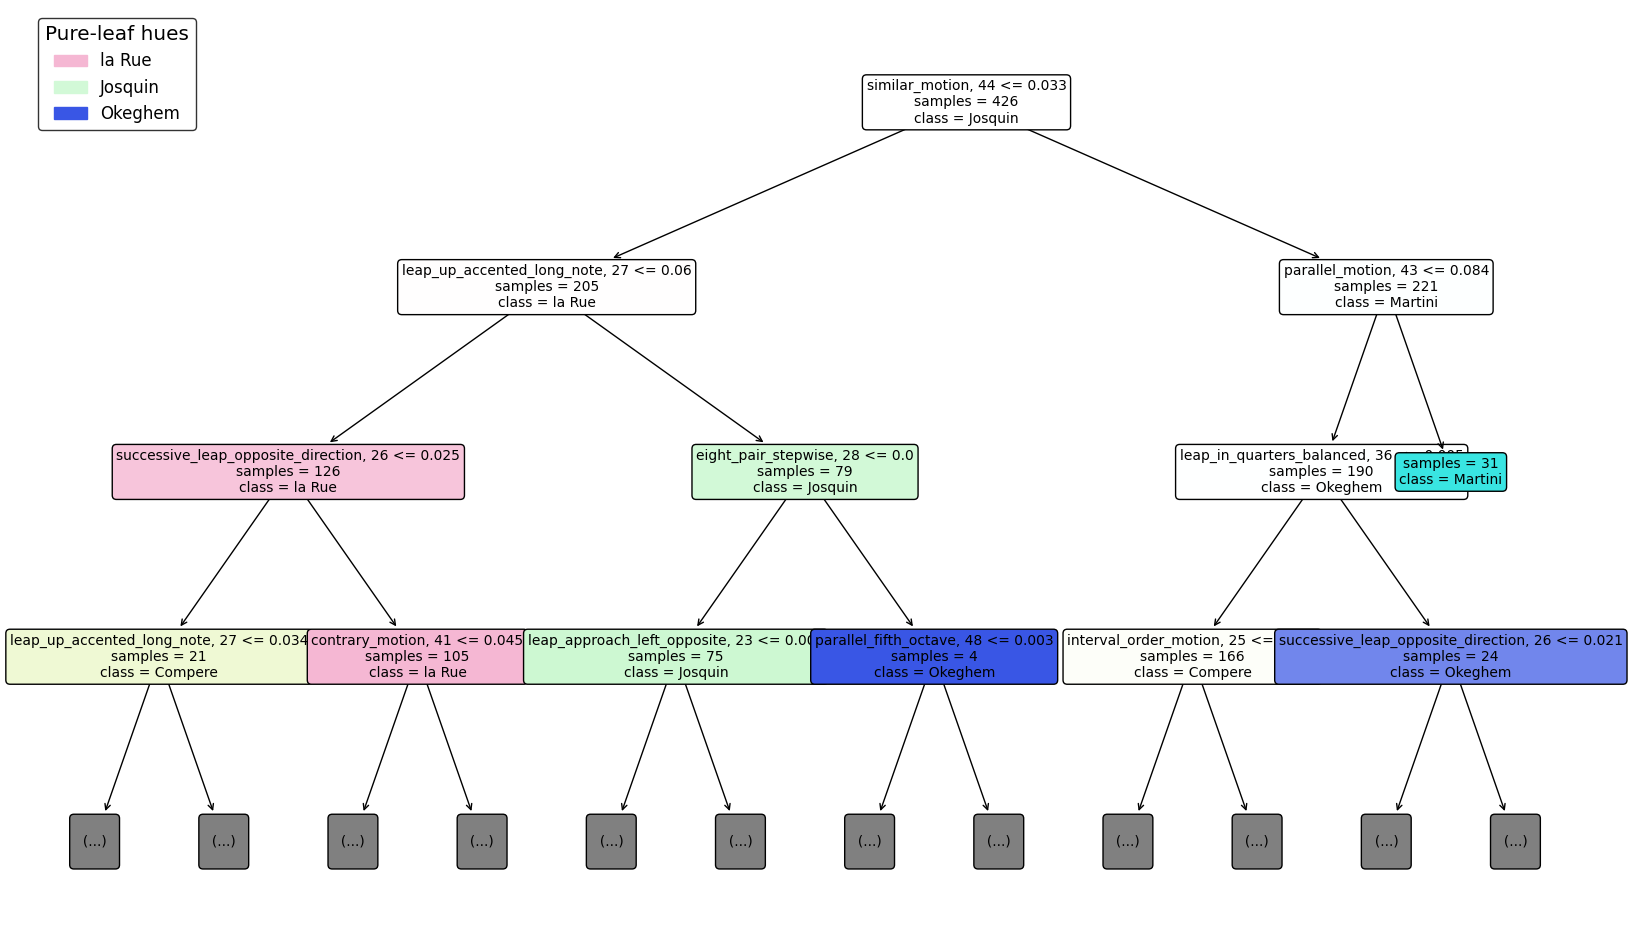

In [35]:
# --- Build legend from the colours actually used by plot_tree ---------
import matplotlib.patches as mpatches
from matplotlib.colors import to_hex
from sklearn.tree import _tree  

# Retrieve names of selected features for plotting
sel_feat = X_train.columns[gs_dt.best_estimator_.named_steps["selector"].get_support()]

# Visualise
plt.figure(figsize=(20, 12))

# Call plot_tree and store the returned list of artists
node_annotations = plot_tree(
    gs_dt.best_estimator_['tree'], # Adjusted for mock object
    feature_names=sel_feat,
    class_names=composer_classes,
    filled=True, 
    rounded=True,
    max_depth=3,
    impurity=False,
    proportion=False,
    fontsize=10
)

for ann in node_annotations:
    text = ann.get_text()
    
    # 1. Correctly split by the actual newline character '\n'
    lines = text.split('\n')
    
    # 2. Use a more robust check ('in') to find the line to remove
    new_lines = [line for line in lines if 'value =' not in line]
    
    # 3. Join the lines back with the newline character '\n'
    new_text = '\n'.join(new_lines)
    
    # Set the modified text back to the annotation
    ann.set_text(new_text)

tree      = gs_dt.best_estimator_.named_steps["tree"]
class_ids = tree.classes_  
                     # order used by plot_tree

tree_struct = tree.tree_
leaf_mask   = tree_struct.children_left == _tree.TREE_LEAF   # Boolean array

pure_hues = {}                                               # {label: RGB}
for ann, is_leaf in zip(node_annotations, leaf_mask):
    if not is_leaf:
        continue                                             # skip non-leaf

    # grab "class = …" line if present
    cls_line = next((l for l in ann.get_text().split('\n')
                     if 'class =' in l), None)
    if cls_line is None:
        continue                                             # defensive: no label

    class_name = cls_line.split('=', 1)[1].strip()

    # fully-saturated colour of this leaf
    rgb = ann.get_bbox_patch().get_facecolor()[:3]           # (r,g,b) 0-1
    pure_hues.setdefault(class_name, rgb)                    # keep first hit

# --- build legend ------------------------------------------------------
legend_patches = [
    mpatches.Patch(color=to_hex(rgb), label=cls)
    for cls, rgb in pure_hues.items()
]
plt.legend(handles=legend_patches,
           title="Pure-leaf hues",
           loc="upper left", frameon=True, edgecolor='k',
           fontsize='large', title_fontsize='x-large')


# SVM

In [36]:
###################3

In [37]:
from sklearn.svm             import LinearSVC
from sklearn.preprocessing    import StandardScaler
from sklearn.pipeline         import Pipeline
from sklearn.model_selection  import cross_validate
import matplotlib.pyplot as plt, numpy as np, pandas as pd
from tqdm.auto import tqdm

# 0️⃣ pipeline skeleton
base_pipe = Pipeline([
    ("scale", StandardScaler(with_mean=False)),
    ("svc",   LinearSVC(
        penalty="l1", dual=False, class_weight="balanced",
        max_iter=5000, random_state=RANDOM_SEED, multi_class="ovr"
    ))
])

# 1️⃣ hyper-parameter sweep
C_grid = np.logspace(-3, 0, 8)     # 0.001 … 10
f1_val, f1_tr = [], []
nz_mean, nz_std = [], []

for C in tqdm(C_grid, desc="LinearSVC-L1 grid"):
    base_pipe.set_params(svc__C=C)
    scores = cross_validate(
        base_pipe, X_train, y_train,
        cv=cv, n_jobs=-1,
        scoring="f1_macro",
        return_train_score=True,
        return_estimator=True
    )

    f1_val.append(scores["test_score"].mean())
    f1_tr.append(scores["train_score"].mean())

    # sparsity — non-zero features
    n_active = [np.count_nonzero(est.named_steps["svc"].coef_.any(axis=0))
                for est in scores["estimator"]]
    nz_mean.append(np.mean(n_active))
    nz_std.append(np.std(n_active))


LinearSVC-L1 grid: 100%|██████████| 8/8 [00:00<00:00,  8.57it/s]



Chosen C = 0.1389


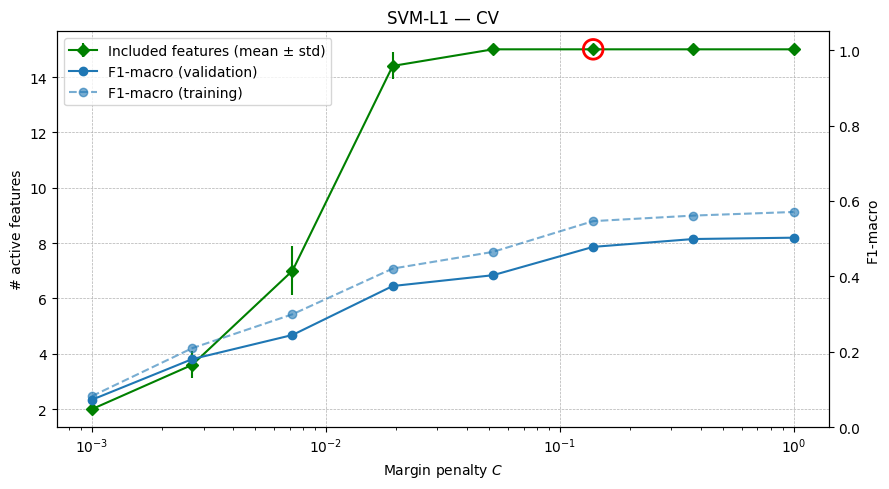

In [38]:


chosen_C = C_grid[5]                      # ← your manual choice
idx_sel  = np.where(C_grid == chosen_C)[0][0]   # index in the grid
y_feat   = nz_mean[idx_sel]                       # y-coord = sparsity curve
print(f"\nChosen C = {chosen_C:.4g}")

# 2️⃣ plot CV results BEFORE final fit
fig, ax1 = plt.subplots(figsize=(9,5))
ax1.set_xscale('log')
ax1.set_xlabel('Margin penalty $C$')
ax1.set_ylabel('# active features', color='black')

ax1.errorbar(C_grid, nz_mean, yerr=nz_std,
             marker='D', color='green', linestyle='-',
             label='Included features (mean ± std)')
ax1.grid(True, linestyle='--', linewidth=0.5)

ax2 = ax1.twinx()
ax2.plot(C_grid, f1_val, 'o-', label='F1-macro (validation)', color='tab:blue')
ax2.plot(C_grid, f1_tr,  'o--', label='F1-macro (training)',   color='tab:blue', alpha=0.6)
ax2.set_ylabel('F1-macro')
ax2.set_ylim(0, 1.05)

# --- draw a red hollow circle around the selected C -------------------
ax1.scatter([chosen_C], [y_feat],
            s=200, facecolors='none', edgecolors='red',
            linewidths=2, zorder=5)

# merge legends
h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper left')

plt.title('SVM-L1 — CV')
plt.tight_layout()
plt.show()


Validation report (Linear SVM-L1):
              precision    recall  f1-score   support

     Busnoys       0.25      0.50      0.33        12
     Compere       0.12      0.20      0.15         5
     Josquin       0.57      0.57      0.57        23
     Martini       1.00      0.48      0.65        23
     Okeghem       0.60      0.50      0.55        12
     de Orto       0.25      0.33      0.29         6
      la Rue       0.70      0.62      0.65        26

    accuracy                           0.51       107
   macro avg       0.50      0.46      0.45       107
weighted avg       0.62      0.51      0.54       107



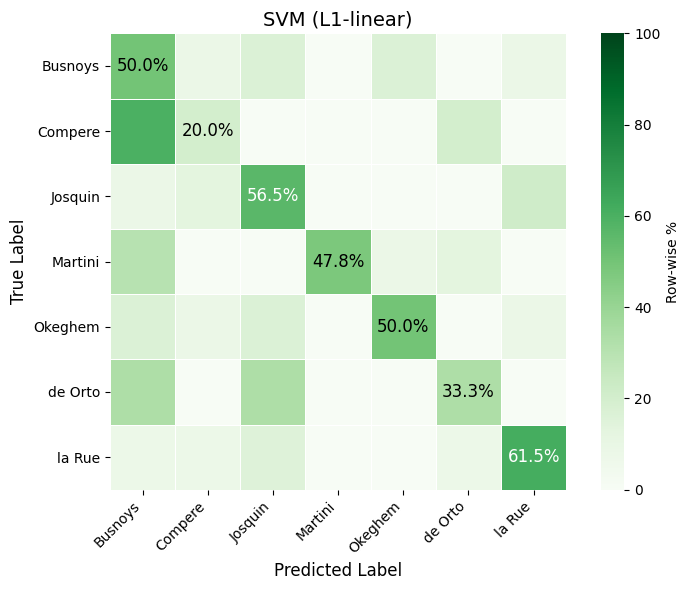


Selected 15 / 15 features (100.0%).


contrary_motion, 41                       0.276803
parallel_motion, 43                       0.221891
successive_leap_opposite_direction, 26    0.183387
leading_tone_approach_step, 32            0.140822
interval_order_motion, 25                 0.136572
Name: Top |coef| for Busnoys, dtype: float64

leap_in_quarters_balanced, 36             0.398221
interval_order_motion, 25                 0.360421
successive_leap_opposite_direction, 26    0.304097
parallel_motion, 43                       0.268405
parallel_fifth_octave, 48                 0.193132
Name: Top |coef| for Compere, dtype: float64

similar_motion, 44                        0.613308
leap_approach_left_opposite, 23           0.208584
leap_up_accented_long_note, 27            0.174856
eight_pair_stepwise, 28                   0.154448
successive_leap_opposite_direction, 26    0.141533
Name: Top |coef| for Josquin, dtype: float64

parallel_motion, 43               0.479753
oblique_motion, 42                0.095528
similar_motion, 44                0.086203
contrary_motion, 41               0.080448
leap_up_accented_long_note, 27    0.048449
Name: Top |coef| for Martini, dtype: float64

parallel_motion, 43                       0.261037
similar_motion, 44                        0.211505
eight_pair_stepwise, 28                   0.202808
successive_leap_opposite_direction, 26    0.179013
leap_up_accented_long_note, 27            0.147085
Name: Top |coef| for Okeghem, dtype: float64

parallel_motion, 43                       0.442623
leap_in_quarters_balanced, 36             0.437843
successive_leap_opposite_direction, 26    0.151274
eight_pair_stepwise, 28                   0.128125
oblique_motion, 42                        0.056488
Name: Top |coef| for de Orto, dtype: float64

contrary_motion, 41               0.305828
leap_up_accented_long_note, 27    0.261715
parallel_motion, 43               0.238170
similar_motion, 44                0.195236
interval_order_motion, 25         0.113667
Name: Top |coef| for la Rue, dtype: float64

In [39]:

# Run on validation set
final_pipe = base_pipe.set_params(svc__C=chosen_C).fit(X_train, y_train)
y_pred = final_pipe.predict(X_val)


print("\nValidation report (Linear SVM-L1):")
print(classification_report(y_val, y_pred, target_names=composer_classes))

cm, _ = plot_confusion_matrix_with_percentages(
    y_val, y_pred, composer_classes, title="SVM (L1-linear)", print_stats=False
)
plt.show()

# -------- sparsity diagnostics ---------------------------------------
coef_abs = np.abs(final_pipe.named_steps["svc"].coef_)
feat_mask = coef_abs.any(axis=0)
print(f"\nSelected {feat_mask.sum()} / {feat_mask.size} features "
      f"({feat_mask.sum()/feat_mask.size:.1%}).")

for idx, name in enumerate(composer_classes):
    weights = pd.Series(final_pipe.named_steps["svc"].coef_[idx],
                        index=X_train.columns)
    display(weights.abs().sort_values(ascending=False).head(5)
            .rename(f"Top |coef| for {name}"))